In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import optimize
from cea_post import Read_datset

# Initial State Requierment (燃焼初期の要求)

In [2]:
# calculation property
m0 = 70 # initial total mass [kg]
Ll = 5.2 # launcher length [m]
vc = 30.5 # required launch clear velocity [m/s]
g = 9.8 # acceleration of gravity [m/s^2]

In [3]:
# calculation
Freq = m0*g + m0*np.power(vc,2)/(2*Ll) # initial required thrust [N]
tc = 2*Ll/vc # launch claer time [s]

**assigned value**  
* Inital toal mass: $m_0$ = {{m0}} kg
* Launcher length: $L_l$ = {{Ll}} m
* Required launch clear velocity: $v_c$ = {{vc}} m/s

**calcualted value**  
Initial required thrust (必要初期推力):  
* $F_{req}$ = {{round(Freq,0)}} N  

Launch clear time (ランチクリア時間):   
* $t_c$ = {{round(tc,3)}} s

# Final Pressure of tank (燃焼終了時のタンク圧力)  
※　酸化剤タンク圧力と気蓄器タンク圧力は等しいとする

In [4]:
# calculation property
gamma_g = 1.4 # specific heat ratio of pressurizing gas
Vg = 3.4e-3 # gas tank volume [m^3]
Vt = 15.0e-3 # liuid oxidizer tank volume [m^3]
Pgi = 14.0e+6 # initial gas tank pressure [MPa]

In [5]:
# calculation part
Ptf = Pgi*np.power(Vg/(Vg+Vt), gamma_g)

**assigned value**
* Specific heat ratio of gas: $\gamma_g$ = {{gamma_g}}
* Gas tank volume: $V_g$ = {{Vg*1.0e+3}} L
* Oxidizer tank volume $V_t$ = {{Vt*1.0e+3}} L
* Intial gas tank pressure = $P_{g,i}$ = {{Pgi*1.0e-6}} MPa

**calculated value**  
Final pressure of tank (燃焼終了時タンク圧力):  
* $P_{t,f}$ = {{round(Ptf*1.0e-6,3)}} MPa

# Required initial oxidizer mass flow rate (必要初期酸化剤流量)

In [6]:
# calculation property
cea_fldpath = os.path.join("cea_db", "LOX_PE","csv_database")
read_cea = Read_datset(cea_fldpath)
func_cstr = read_cea.gen_func("CSTAR")
func_gamma = read_cea.gen_func("GAMMAs_c")
eta = 0.8 # c* efficiency
Pci = 3.0e+6 # initial chamber pressure [MPa]
Pei = 0.1013e+6 # initial nozzle exit pressure [MPa]. in this case, the value is eqaualt to atmospheric pressure; 1 atm.
ofi = 3.0 # initial O/F

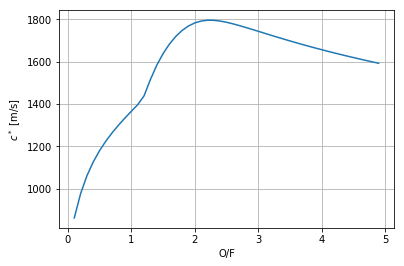

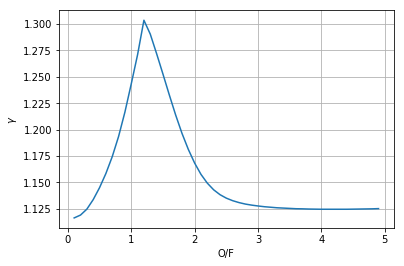

In [7]:
%matplotlib inline
of_plotrange = np.arange(0.1, 5.0, 0.1)
plt.plot(of_plotrange, np.array([func_cstr(of, Pci)  for of in of_plotrange]))
plt.grid()
plt.xlabel("O/F")
plt.ylabel("$c^*$ [m/s]")
plt.show()
plt.plot(of_plotrange, np.array([func_gamma(of, Pci)  for of in of_plotrange]))
plt.grid()
plt.ylabel("$\gamma$")
plt.xlabel("O/F")
plt.show()

In [8]:
# calcualtion part
gamma_i = func_gamma(ofi, Pci)
cstr_i = func_cstr(ofi, Pci)
CFi_tmp = np.sqrt(2*np.power(gamma_i,2)/(gamma_i-1) *np.power(2/(gamma_i+1), (gamma_i+1)/(gamma_i-1)) *(1-np.power(Pei/Pci, (gamma_i-1)/gamma_i))) # thrust coefficient
mp_req = Freq/(CFi_tmp*eta*cstr_i)
mox_req = (ofi/(1+ofi))*mp_req

**assigned value**  
* $P_{c,i}$ = {{Pci*1.e-6}} MPa  
* $P_{e,i}$ = {{Pei* 1.e-6}} MPa  
* $O/F_i$ = {{ofi}}
* $\eta_{c^*}$ = {{eta}}



**calculated value**  
$\gamma_i$ = {{gamma_i}}   
$c^*_i$ = {{cstr_i}} m/s  
$C_{F,i}$ = {{CFi_tmp}}  
$\dot m_{p,req}$ = {{mp_req}} kg/s  

**Required initial oxidizer mass flow rate (必要初期酸化剤流量)**:  
* $\dot m_{ox,req}$ = {{mox_req}} kg/s

# Determin the number of injector port and Cv  (必要なインジェクタポート数とCv値の推定)

In [9]:
# calculation property
Cd = 0.82 # discharge coefficient
D_inj = 1.0e-3 # injector port diameter [m]
rho_ox = 1190 # oxidizer density [kg/m^3]
# Pti = Pgi # intial oxidizer tank pressure [Pa]. In this case, the value is equal to initial gas tank pressure
Pti = 5.0e+6 # intial oxidizer tank pressure [Pa]. In this case, the value is set by regulator

In [10]:
# calcuration part
N_req = 4*mox_req/(np.power(D_inj,2)*np.pi*Cd*np.sqrt(2*rho_ox*(Pti-Pci)))
Cv = mox_req/np.sqrt(2*rho_ox*(Pti-Pci))

**assigned value**  
* $C_d$ = {{Cd}}
* $D_{inj}$ = {{D_inj*1.0e+3}} mm
* $\rho_{ox}$ = {{rho_ox}} kg/m$^3$

**calculated value**  
Required the number of injector port (必要なインジェクタポート数):  
* $N_{req}$ = {{N_req}} 個  

Cv値  
* $C_{v,req}$ = {{Cv}}

# Determin the diameter of nozzle throat (必要ノズルスロート径の推定)

In [11]:
# calculation property
N_inj = 56 # the number of injecotr port
Cv = N_inj*Cd*np.pi*np.power(D_inj,2)/4 # Cv; mass flow rate coefficeint

In [12]:
# calculatioin part
mox_i = Cv*np.sqrt(2*rho_ox*(Pti-Pci))
mp_i = mox_i*(1+1/ofi)
Fi_tmp = CFi_tmp*eta*cstr_i*mp_i
Dti_tmp = np.sqrt(4*eta*mp_i*cstr_i/(np.pi*Pci))
Pe = 0.1013e+6
eps_tmp = np.power((2/(gamma_i+1)), 1/(gamma_i-1)) * np.power(Pci/Pe, 1/gamma_i) / np.sqrt((gamma_i+1)/(gamma_i-1)*(1-np.power(Pe/Pci, (gamma_i-1)/gamma_i)))
De_tmp = np.sqrt(eps_tmp)*Dti_tmp

**assigned value**  
the number of injector port: 
* $N_{inj}$ = {{N_inj}} 個  

coefficient of oxidizer mass flow rate:  
* $C_v$ = {{Cv}}  

**calculated value**  
Initial oxidizer mass flow rate  
* $m_{ox,i}$ = {{mox_i}} kg/s  

Initial propelant mass flow rate  
* $m_{p,i}$ = {{mp_i}} kg/s  

Initial thrust (temporal) 
* $F_{i,tmp}$ = {{Fi_tmp}} N  

Nozzle throat diamter  
* $D_{t,i,tmp}$ = {{Dti_tmp*1.0e+3}} mm

Nozzle Area ratio
* $\epsilon_{tmp}$ = {{eps_tmp}}

Nozzle exit diamter
* $D_{e,tmp}$ = {{De_tmp*1.0e+3}} mm

# Select thrust coefficient and diamter of nozzle throat and nozzle exit (CFとノズルスロート，出口径の選択)

In [13]:
# calculation property
Dti = 44e-3 #[m] nozzle throat diameter
De = 103e-3 #[m] nozzle exit diameter

eps_range = np.arange(2,10,0.1)
P_ratio_range = np.arange(10,40,5) # Pc/Pa

C:\Users\TJ\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: RuntimeWarning: invalid value encountered in power


Text(0,0.5,'CF')

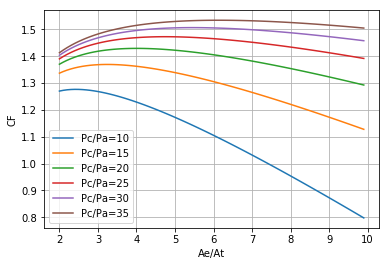

In [14]:
# Plot part
% matplotlib inline

def iterat_Pe(of, Pc, eps):
    """
    of: float
        O/F
    Pc: float
        Chamber pressure [Pa]
    eps: float
        Nozzle expansion ratio
    """
    if of<=0:
        of = 1.0e-2
    try:
        Pe = optimize.newton(func_error_eps, Pc/2, maxiter=100, tol=1.0e-3, args=(of, Pc, eps))
    except:
        Pe = optimize.brentq(func_error_eps, 1, Pc/2, maxiter=100, xtol=1.0e-3, full_output=False, args=(of, Pc,eps))
    return(Pe)

def func_error_eps(Pe, of , Pc, eps):
    eps_cal = func_eps_cal(Pe, of, Pc)
    diff = eps_cal - eps
    error = diff/eps_cal
    return(error)

def func_eps_cal(Pe, of, Pc):
    if Pe == 0:
        Pe = self.Pa
    if Pc == 0:
        Pc = Pe
    eps_cal = np.power((2/(gamma_i+1)), 1/(gamma_i-1)) * np.power(Pc/Pe, 1/gamma_i) / np.sqrt((gamma_i+1)/(gamma_i-1)*(1-np.power(Pe/Pc, (gamma_i-1)/gamma_i)))
    return(eps_cal)

for P_ratio in P_ratio_range:
    Pc_tmp = eta*cstr_i*mp_i/(np.pi*np.power(Dti,2)/4)
    Pa_tmp = Pc_tmp/P_ratio
    Pe_tmp = np.array([iterat_Pe(ofi, Pc_tmp,eps_plot) for eps_plot in eps_range])
    CF_plot = np.sqrt(2*np.power(gamma_i,2)/(gamma_i-1) *np.power(2/(gamma_i+1), (gamma_i+1)/(gamma_i-1)) *(1-np.power(Pe_tmp/Pc_tmp, (gamma_i-1)/gamma_i))) + (Pe_tmp/Pc_tmp - Pa_tmp/Pc_tmp)*eps_range # thrust coefficient
    plt.plot(eps_range, CF_plot, label="Pc/Pa={}".format(P_ratio))
plt.legend()
plt.grid()
plt.xlabel("Ae/At")
plt.ylabel("CF")

In [34]:
# Calculation Part
eps = np.power(De/Dti, 2)
Pci = eta*cstr_i*mp_i/(np.pi*np.power(Dti,2)/4)
Pei = iterat_Pe(ofi, Pci, eps)
CFi = np.sqrt(2*np.power(gamma_i,2)/(gamma_i-1) *np.power(2/(gamma_i+1), (gamma_i+1)/(gamma_i-1)) *(1-np.power(Pei/Pci, (gamma_i-1)/gamma_i))) + (Pei/Pci - 0.1013e+6/Pci)*eps # thrust coefficient

C:\Users\TJ\Anaconda3\lib\site-packages\ipykernel\__main__.py:32: RuntimeWarning: invalid value encountered in power


**Assigned value**  
Nozzle throat diameter:
* $D_{t,i}$ = {{Dti*1.0e+3}} mm  

Nozzle exit diameter:  
* $D_e$ = {{De*1.0e+3}} mm  

**Calculated value**  
Chamber pressure  
* $P_c$ = {{Pci*1.0e-6}} MPa  

Nozzle area ratio  
* $Ae/At: \epsilon$ = {{eps}}  

Nozzle exit pressure  
* $P_e$ = {{Pei*1.0e-6}} MPa  

Trhust coefficeint
* $C_F$ = {{CFi}}

# Fuel length, port diameter and the number of port (燃料長さと燃料ポート径，ポート数の推定)

## 採用する燃料後退速度式の決定

### 後退速度式の係数に関する単位変換　($\dot r$ : mm/s → m/s,  $G_{ox}$ : g/cm$^2$-s → kg/m$^2$-s)

In [16]:
# coefficient, a, written in mm/s and g/cm^2-s unit
a_org = 0.132
n = 0.498
a = a_org*np.power(10, -(n+3))
print("a={}".format(a))

a=4.1934737732576954e-05


### 各係数の指定

In [17]:
a = 4.19347377e-5 # coefficient of oxidizer mass flux
n = 0.498 # exponential factor of oxidizer mass flux

## 各ポート数に対する，必要な燃料長さとポート径

In [18]:
# calculation property
rho_f = 950 # fuel density [kg/m^3]

In [31]:
def Lf_req(Np, Df):
    Gox = func_Gox(Np, Df)
    r = func_r(Gox)
    af = func_af(Np, Df)
    Lf = (mox_i/ofi)/(af*rho_f*r)
    return(Lf)

def Lf_req_Rf(Np, Rf1):
    Gox = func_Gox(Np, 2*Rf1)
    r = func_r(Gox)
    af = func_af(Np, Df)
    Lf = (mox_i/ofi)/(af*rho_f*r)
    
def func_af(Np, Df):
    """ calculate burning area per unit length """
    Af = np.pi*Df*Np
    return(Af)
    
def func_Gox(Np, Df):
    Gox = mox_i/(Np*np.pi*np.power(Df,2)/4)
    return(Gox)

def func_r(Gox):
    r = a*np.power(Gox, n)
    return(r)

def func_Rf(Np, Df):
    """ calculate the length of sector-shape port-radius """
    Rf = Df*np.sqrt(Np/4)
    return(Rf)


def iterat_Rf1(Np, t, Df):
    """ Calculate the center port radius and sector-shape height of wagon-wheel type fuel 
    
    Parameter
    ---------
    Np: float
        the number of port diameter
    t: float
        web half thickness
    Df: float
        equivalent single port diameter [m]
    
    Return
    ------------
    (Rf1, Rf2): tuple
        Rf1: center port radius
        Rf2: sector-shape height
        
    """
    Rf1 = optimize.newton(func_error_S1, 10.0e-3, maxiter=100, args=(Np, t, Df))
#     Rf1 = optimize.brentq(func_error_S1, 1.0e-3, 100.0e-3, args=(Np, t, Df))
    Rf2 = iterat_Rf2(Np, t, Rf1)
    return(Rf1, Rf2)

def func_error_S1(Rf1, Np, t, Df):
    Rf2 = iterat_Rf2(Np, t, Rf1)
    S2 = func_S2(Np, t, Rf1, Rf2)
    S1 = np.pi*np.power(Rf1, 2)
    diff = S1 + (Np-1)*S2 -np.pi*np.power(Df,2)/4
    error = diff/(np.pi*np.power(Df,2)/4)
    return(error)
    
def iterat_Rf2(Np, t, Rf1):
    Rf2 = optimize.newton(func_error_S2, 10.0e-3, maxiter=100, args=(Np, t, Rf1))
#     Rf2 = optimize.brentq(func_error_S2, 1.0e-3, 100.0e-3, args=(Np, t, Rf1))
    return(Rf2)
    
def func_error_S2(Rf2, Np, t, Rf1):
    S1 = np.pi*np.power(Rf1, 2)
    S2 = func_S2(Np, t, Rf1, Rf2)
    error = (S1 - S2)/S2
    return(error)
    
def func_S2(Np, t, Rf1, Rf2):
    theta = np.arcsin(t/(Rf1 + 2*t))
    fai = np.arcsin(t/(Rf1 + 2*t + Rf2))
    psi = theta - fai
    alpha = 2*np.pi/(Np-1) - 2*theta
    s0 = np.power(Rf1 + 2*t + Rf2, 2)*theta/2
    s1 = np.power(Rf1 + 2*t + Rf2, 2)*fai/2
    s2 = (Rf1 + 2*t)*np.sin(psi)*(Rf1 + 2*t + Rf2)/2
    smin = s0 - (s1 + s2)
    S2 = 2*smin + np.power(Rf1 + 2*t + Rf2, 2)*alpha/2 - np.power(Rf1 + 2*t, 2)*alpha/2
    return(S2)

Np=13
t = 8e-3
Df = 100.0e-3
Rf1, Rf2 = iterat_Rf1(Np, t, Df)
print("Rf1={}".format(Rf1))
print("Rf2={}".format(Rf2))
print("D_f,eq="+ str(np.sqrt(Np)*2*Rf1))
print("S1 = "+str(np.power(2*Rf1, 2)*np.pi/4))
print("S2 = "+str(func_S2(Np, t, Rf1, Rf2)))
print("S1 + Np*S2 = " +str(np.power(2*Rf1, 2)*np.pi/4 + (Np-1)*func_S2(Np, t, Rf1, Rf2)))
print("pi*Df^2/4 = "+str(np.power(Df, 2)*np.pi/4))

def func_Df_out(Rf1, t, Rf2):
    Df_out = 2*(Rf1 + 2*t + Rf2 + t)
    return(Df_out)

Rf1=0.013867504904522834
Rf2=0.04887680532806933
D_f,eq=0.099999999992
S1 = 0.000604152433286
S2 = 0.000604152433282
S1 + Np*S2 = 0.00785398163267
pi*Df^2/4 = 0.00785398163397


### $N_p$=1

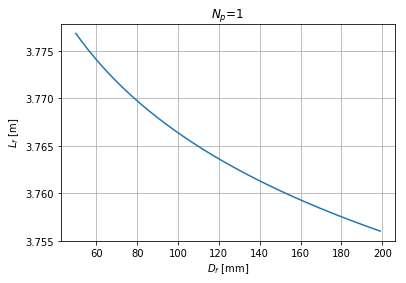

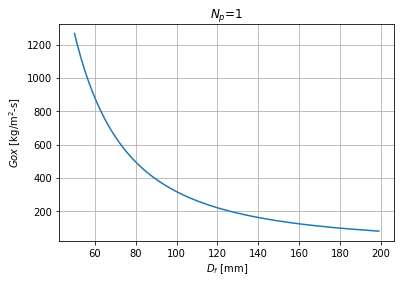

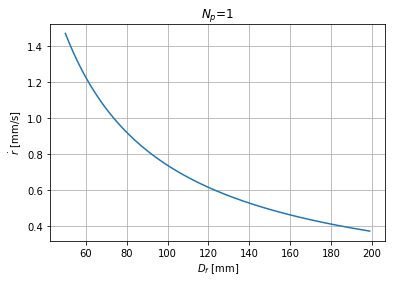

In [20]:
N_p = 1
Df_plotrange = np.arange(50, 200, 1)*1.0e-3

%matplotlib inline
plt.plot(Df_plotrange*1.0e+3, Lf_req(N_p, Df_plotrange))
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$L_f$ [m]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

plt.plot(Df_plotrange*1.0e+3, func_Gox(N_p, Df_plotrange))
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$Gox$ [kg/m$^2$-s]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

Gox_plotrange = func_Gox(N_p, Df_plotrange)
plt.plot(Df_plotrange*1.0e+3, func_r(Gox_plotrange)*1.0e+3)
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$\dot r$ [mm/s]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

### $N_p$=5

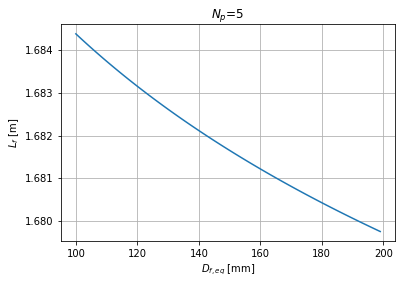

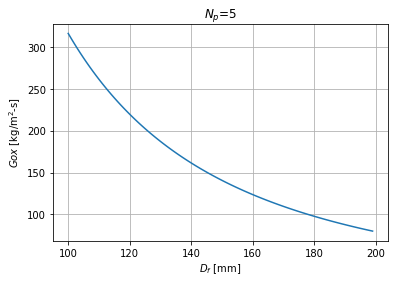

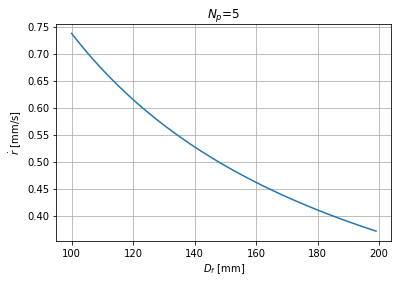

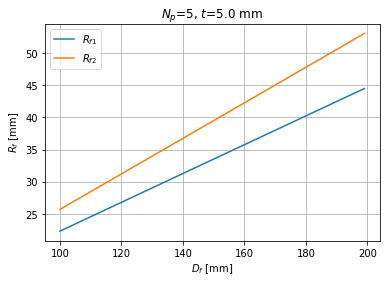

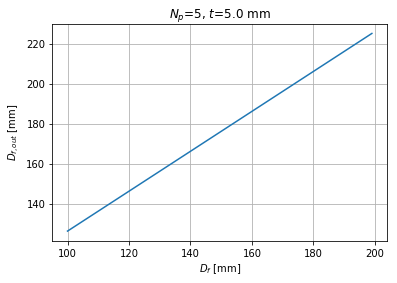

In [21]:
N_p = 5
t = 5.0e-3 # web half thickness [m]
Df_plotrange = np.arange(100, 200, 1)*1.0e-3

%matplotlib inline

Rf = np.array([iterat_Rf1(N_p, t, Df) for Df in Df_plotrange])
Rf1 = Rf[:,0]
Rf2 = Rf[:,1]

plt.plot(Df_plotrange*1.0e+3, Lf_req(N_p, 2*Rf1))
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$L_f$ [m]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

plt.plot(Df_plotrange*1.0e+3, func_Gox(N_p, 2*Rf1))
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$Gox$ [kg/m$^2$-s]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

Gox_plotrange = func_Gox(N_p, 2*Rf1)
plt.plot(Df_plotrange*1.0e+3, func_r(Gox_plotrange)*1.0e+3)
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$\dot r$ [mm/s]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()


plt.plot(Df_plotrange*1.0e+3, Rf1*1.0e+3, label="$R_{f1}$")
plt.plot(Df_plotrange*1.0e+3, Rf2*1.0e+3, label="$R_{f2}$")
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$R_f$ [mm]")
plt.title("$N_p$={}, $t$={} mm".format(N_p, t*1.0e+3))
plt.legend()
plt.grid()
plt.show()

plt.plot(Df_plotrange*1.0e+3, func_Df_out(Rf1, t, Rf2)*1.0e+3)
plt.xlabel("$D_f$ [mm]")
plt.ylabel("$D_{f,out}$ [mm]")
plt.title("$N_p$={}, $t$={} mm".format(N_p, t*1.0e+3))
plt.grid()
plt.show()

### $N_p$=7

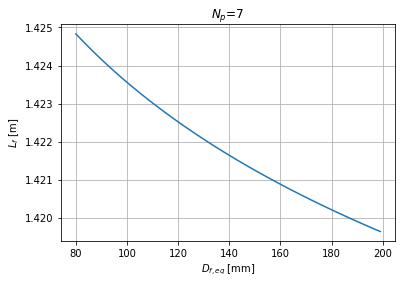

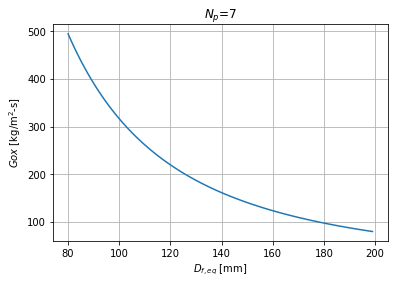

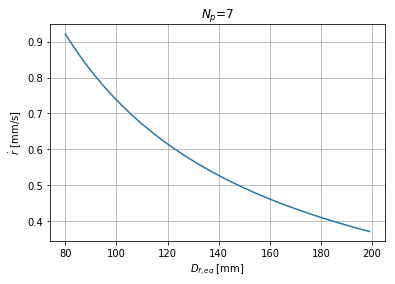

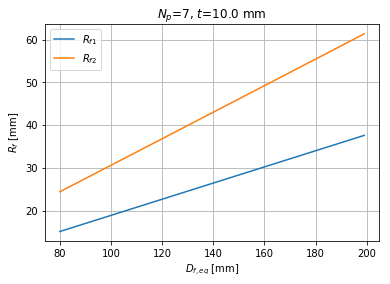

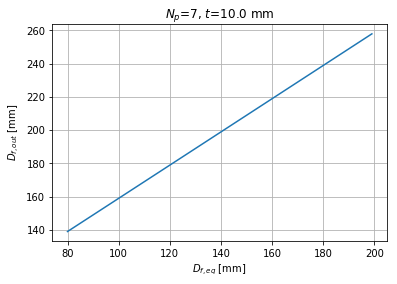

In [22]:
N_p = 7
t = 10.0e-3 # web half thickness [m]
Df_plotrange = np.arange(80, 200, 1)*1.0e-3

%matplotlib inline

Rf = np.array([iterat_Rf1(N_p, t, Df) for Df in Df_plotrange])
Rf1 = Rf[:,0]
Rf2 = Rf[:,1]

plt.plot(Df_plotrange*1.0e+3, Lf_req(N_p, 2*Rf1))
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$L_f$ [m]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

plt.plot(Df_plotrange*1.0e+3, func_Gox(N_p, 2*Rf1))
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$Gox$ [kg/m$^2$-s]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

Gox_plotrange = func_Gox(N_p, 2*Rf1)
plt.plot(Df_plotrange*1.0e+3, func_r(Gox_plotrange)*1.0e+3)
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$\dot r$ [mm/s]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()


plt.plot(Df_plotrange*1.0e+3, Rf1*1.0e+3, label="$R_{f1}$")
plt.plot(Df_plotrange*1.0e+3, Rf2*1.0e+3, label="$R_{f2}$")
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$R_f$ [mm]")
plt.title("$N_p$={}, $t$={} mm".format(N_p, t*1.0e+3))
plt.legend()
plt.grid()
plt.show()

plt.plot(Df_plotrange*1.0e+3, func_Df_out(Rf1, t, Rf2)*1.0e+3)
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$D_{f,out}$ [mm]")
plt.title("$N_p$={}, $t$={} mm".format(N_p, t*1.0e+3))
plt.grid()
plt.show()

### $N_p$=8

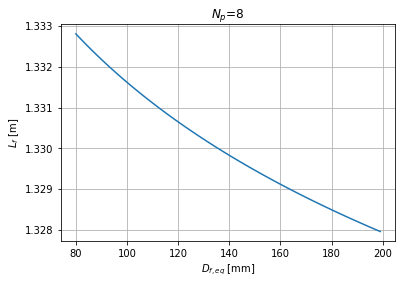

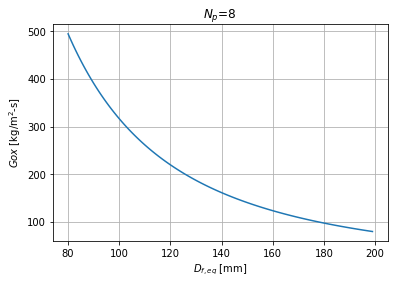

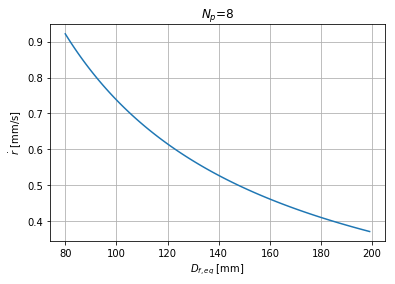

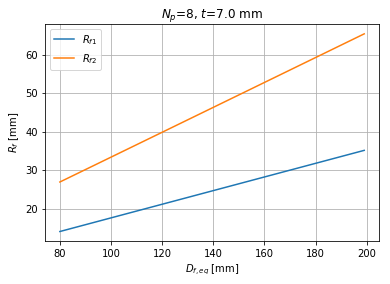

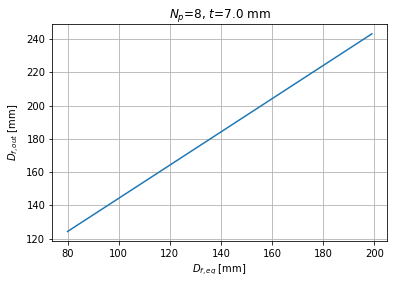

In [23]:
N_p = 8
t = 7.0e-3 # web half thickness [m]
Df_plotrange = np.arange(80, 200, 1)*1.0e-3

%matplotlib inline

Rf = np.array([iterat_Rf1(N_p, t, Df) for Df in Df_plotrange])
Rf1 = Rf[:,0]
Rf2 = Rf[:,1]

plt.plot(Df_plotrange*1.0e+3, Lf_req(N_p, 2*Rf1))
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$L_f$ [m]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

plt.plot(Df_plotrange*1.0e+3, func_Gox(N_p, 2*Rf1))
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$Gox$ [kg/m$^2$-s]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

Gox_plotrange = func_Gox(N_p, 2*Rf1)
plt.plot(Df_plotrange*1.0e+3, func_r(Gox_plotrange)*1.0e+3)
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$\dot r$ [mm/s]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()


plt.plot(Df_plotrange*1.0e+3, Rf1*1.0e+3, label="$R_{f1}$")
plt.plot(Df_plotrange*1.0e+3, Rf2*1.0e+3, label="$R_{f2}$")
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$R_f$ [mm]")
plt.title("$N_p$={}, $t$={} mm".format(N_p, t*1.0e+3))
plt.legend()
plt.grid()
plt.show()

plt.plot(Df_plotrange*1.0e+3, func_Df_out(Rf1, t, Rf2)*1.0e+3)
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$D_{f,out}$ [mm]")
plt.title("$N_p$={}, $t$={} mm".format(N_p, t*1.0e+3))
plt.grid()
plt.show()

### $N_p$=9

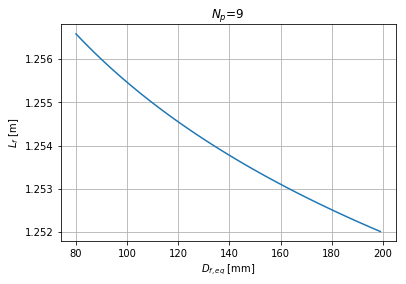

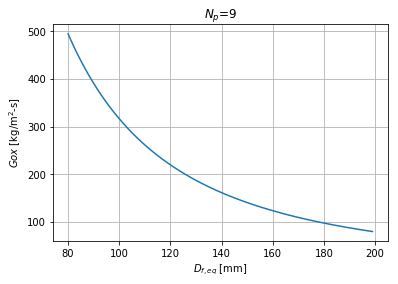

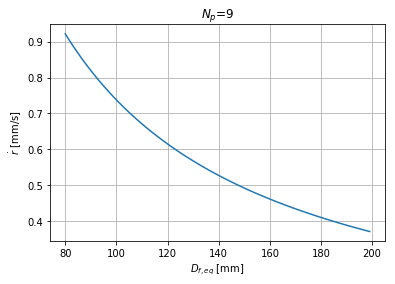

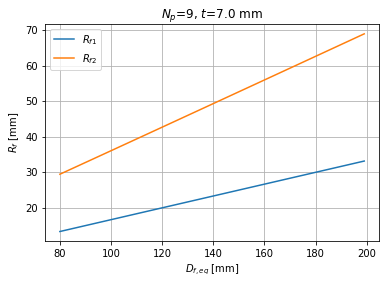

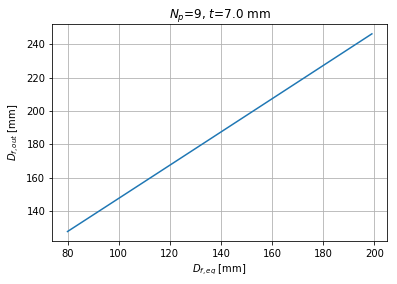

In [24]:
N_p = 9
t = 7.0e-3 # web half thickness [m]
Df_plotrange = np.arange(80, 200, 1)*1.0e-3

%matplotlib inline

Rf = np.array([iterat_Rf1(N_p, t, Df) for Df in Df_plotrange])
Rf1 = Rf[:,0]
Rf2 = Rf[:,1]

plt.plot(Df_plotrange*1.0e+3, Lf_req(N_p, 2*Rf1))
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$L_f$ [m]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

plt.plot(Df_plotrange*1.0e+3, func_Gox(N_p, 2*Rf1))
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$Gox$ [kg/m$^2$-s]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

Gox_plotrange = func_Gox(N_p, 2*Rf1)
plt.plot(Df_plotrange*1.0e+3, func_r(Gox_plotrange)*1.0e+3)
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$\dot r$ [mm/s]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()


plt.plot(Df_plotrange*1.0e+3, Rf1*1.0e+3, label="$R_{f1}$")
plt.plot(Df_plotrange*1.0e+3, Rf2*1.0e+3, label="$R_{f2}$")
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$R_f$ [mm]")
plt.title("$N_p$={}, $t$={} mm".format(N_p, t*1.0e+3))
plt.legend()
plt.grid()
plt.show()

plt.plot(Df_plotrange*1.0e+3, func_Df_out(Rf1, t, Rf2)*1.0e+3)
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$D_{f,out}$ [mm]")
plt.title("$N_p$={}, $t$={} mm".format(N_p, t*1.0e+3))
plt.grid()
plt.show()

### $N_p$=13

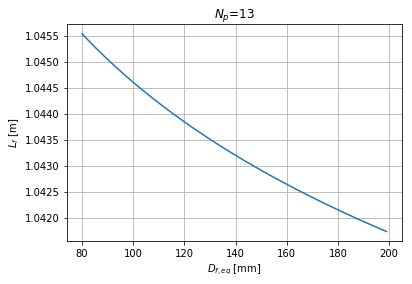

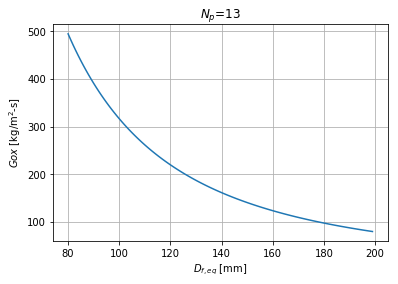

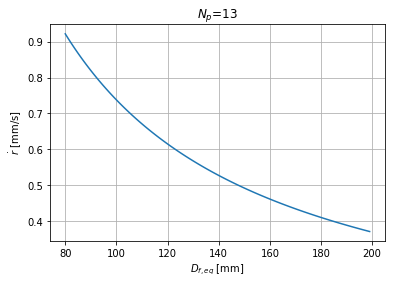

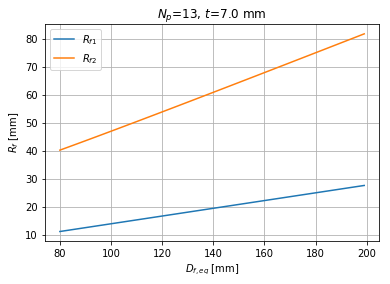

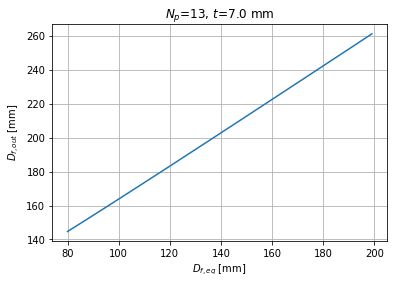

In [25]:
### $N_p$=13

N_p = 13
t = 7.0e-3 # web half thickness [m]
Df_plotrange = np.arange(80, 200, 1)*1.0e-3

%matplotlib inline

Rf = np.array([iterat_Rf1(N_p, t, Df) for Df in Df_plotrange])
Rf1 = Rf[:,0]
Rf2 = Rf[:,1]

plt.plot(Df_plotrange*1.0e+3, Lf_req(N_p, 2*Rf1))
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$L_f$ [m]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

plt.plot(Df_plotrange*1.0e+3, func_Gox(N_p, 2*Rf1))
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$Gox$ [kg/m$^2$-s]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()

Gox_plotrange = func_Gox(N_p, 2*Rf1)
plt.plot(Df_plotrange*1.0e+3, func_r(Gox_plotrange)*1.0e+3)
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$\dot r$ [mm/s]")
plt.title("$N_p$={}".format(N_p))
plt.grid()
plt.show()


plt.plot(Df_plotrange*1.0e+3, Rf1*1.0e+3, label="$R_{f1}$")
plt.plot(Df_plotrange*1.0e+3, Rf2*1.0e+3, label="$R_{f2}$")
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$R_f$ [mm]")
plt.title("$N_p$={}, $t$={} mm".format(N_p, t*1.0e+3))
plt.legend()
plt.grid()
plt.show()

plt.plot(Df_plotrange*1.0e+3, func_Df_out(Rf1, t, Rf2)*1.0e+3)
plt.xlabel("$D_{f,eq}$ [mm]")
plt.ylabel("$D_{f,out}$ [mm]")
plt.title("$N_p$={}, $t$={} mm".format(N_p, t*1.0e+3))
plt.grid()
plt.show()